In [1]:
########################################
# STEP 0: import libraries
########################################
import pandas as pd
import sklearn.datasets
import sklearn.decomposition
import sklearn.discriminant_analysis
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.random_projection
import sklearn.tree
import sklearn.svm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBClassifier
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from pathlib import Path

# Generate features

In [2]:
data_path = Path('./') / 'data'
train = pd.read_csv(data_path / "train.csv")
client = pd.read_csv(data_path / "client.csv")
historical_weather = pd.read_csv(data_path / "historical_weather.csv")
forecast_weather = pd.read_csv(data_path / "forecast_weather.csv")
electricity = pd.read_csv(data_path / "electricity_prices.csv")
gas = pd.read_csv(data_path / "gas_prices.csv")

location = (pd.read_csv(data_path / "county_lon_lats.csv")
            .drop(columns=["Unnamed: 0"])
           )


In [31]:
class FeatureProcessorClass():
    def __init__(self):         
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def create_data_features(self, data):
        '''📊Create features for main data (test or train) set📊'''
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        data['hour'] = data['datetime'].dt.hour
        
        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        '''💼 Create client features 💼'''
        # Modify column names - specify suffix
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client
    
    def create_historical_weather_features(self, historical_weather):
        '''⌛🌤️ Create historical weather features 🌤️⌛'''
        
        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        
        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        
        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return historical_weather
    
    def create_forecast_weather_features(self, forecast_weather):
        '''🔮🌤️ Create forecast weather features 🌤️🔮'''
        
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )
        
        # To datetime
        forecast_weather['datetime'] = (pd.to_datetime(forecast_weather['datetime'])
                                        .dt
                                        .tz_localize(None)
                                       )

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)
        
        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)     
        return forecast_weather

    def create_electricity_features(self, electricity):
        '''⚡ Create electricity prices features ⚡'''
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        
        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )             
        return electricity

    def create_gas_features(self, gas):
        '''⛽ Create gas prices features ⛽'''
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        
        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas, 
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )       
        return gas
    
    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)
        
        # 🔗 Merge all datasets into one df 🔗
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df
    
def create_revealed_targets_train(data, N_day_lags):
    '''🎯 Create past revealed_targets for train set based on number of day lags N_day_lags 🎯 '''    
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # Create revealed targets for all day lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [32]:
# Generate features for training data
# NOTE: this can take a little bit to run
FeatureProcessor = FeatureProcessorClass()
N_day_lags = 15  # incorporate data from historical 15 days

data = FeatureProcessor(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity.copy(),
                      gas = gas.copy(),
                     )

df = create_revealed_targets_train(data.copy(), 
                                  N_day_lags = N_day_lags)

In [33]:
# Save features to CSV
df.to_csv('train_features.csv', index = False)

In [34]:
df.shape

(2018352, 71)

In [35]:
df.drop(columns = ['prediction_unit_id', 'data_block_id', 'row_id', 'hour_h', 'date_client', 'origin_date_gas', 'forecast_date_gas', 'origin_date_electricity'], inplace = True)
df.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'date', 'year', 'quarter', 'month', 'week', 'hour',
       'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client',
       'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean',
       'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean',
       'cloudcover_total_h_mean', 'cloudcover_low_h_mean',
       'cloudcover_mid_h_mean', 'cloudcover_high_h_mean',
       'windspeed_10m_h_mean', 'winddirection_10m_h_mean',
       'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean',
       'diffuse_radiation_h_mean', 'hours_ahead_f_mean', 'temperature_f_mean',
       'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean',
       'cloudcover_mid_f_mean', 'cloudcover_total_f_mean',
       '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean',
       'direct_solar_radiation_f_mean',
       'surface_solar_radiation_downwards_f_mean', 'sno

# Visualizing and Exploring Data

/var/folders/w3/ln3yv35d7tvd419758qpxvhm0000gn/T/ipykernel_37862/1782256650.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  energy = df.groupby(['date', 'is_consumption'])['target'].sum().reset_index()


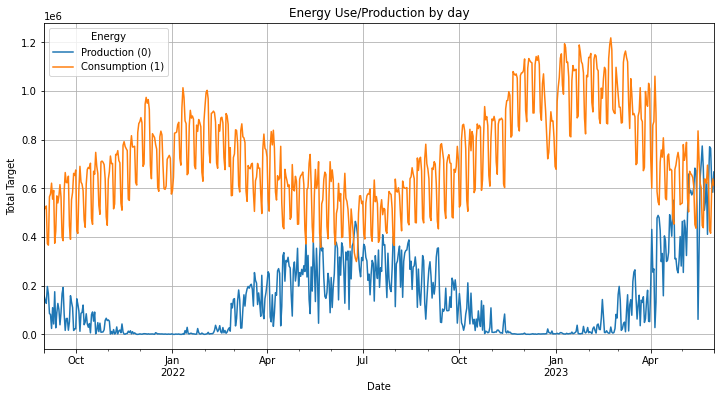

In [36]:
energy = df.groupby(['date', 'is_consumption'])['target'].sum().reset_index()

# Pivot the data so each is_consumption value gets its own column
pivoted_energy = energy.pivot(index='date', columns='is_consumption', values='target')

# Plotting
pivoted_energy.plot(kind='line')
plt.title('Energy Use/Production by day')
plt.xlabel('Date')
plt.gcf().set_size_inches(12, 6)  # Set the figure size to make the plot larger
plt.ylabel('Total Target')
plt.legend(title='Energy', labels=['Production (0)', 'Consumption (1)'])
plt.grid(True)
plt.show()


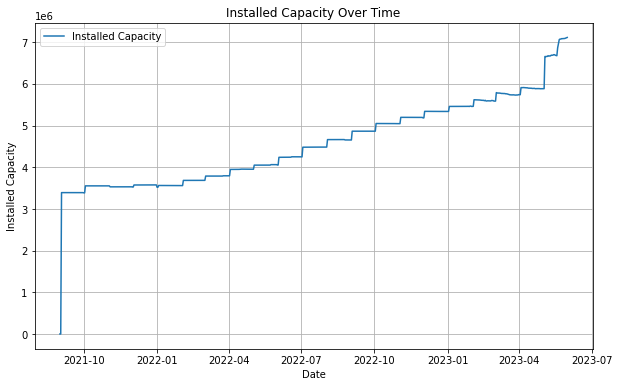

In [37]:
capacity = df.groupby(['date'])['installed_capacity_client'].sum().reset_index()
# Plotting capacity over date
plt.figure(figsize=(10, 6))
plt.plot(capacity['date'], capacity['installed_capacity_client'], label='Installed Capacity')
plt.title('Installed Capacity Over Time')
plt.xlabel('Date')
plt.ylabel('Installed Capacity')
plt.legend()
plt.grid(True)
plt.show()

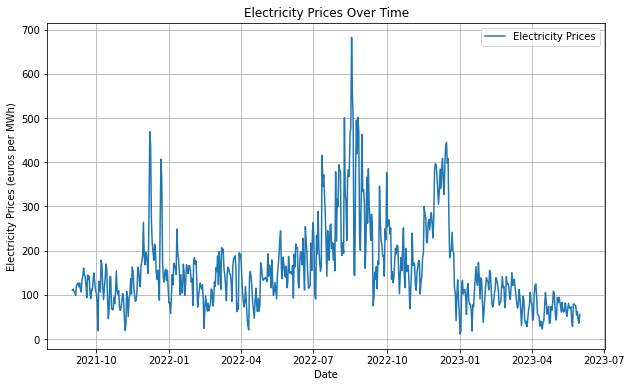

In [38]:
electricity_prices = df.groupby(['date'])['euros_per_mwh_electricity'].mean().reset_index()
# Plotting capacity over date
plt.figure(figsize=(10, 6))
plt.plot(electricity_prices['date'], electricity_prices['euros_per_mwh_electricity'], label='Electricity Prices')
plt.title('Electricity Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Electricity Prices (euros per MWh)')
plt.legend()
plt.grid(True)
plt.show()

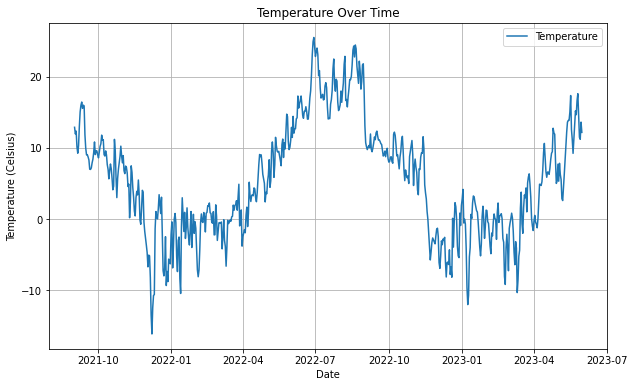

In [39]:
temp = df.groupby(['date'])['temperature_h_mean'].mean().reset_index()
# Plotting temp over date
plt.figure(figsize=(10, 6))
plt.plot(temp['date'], temp['temperature_h_mean'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.grid(True)
plt.show()

Splitting data into consumption and production

In [48]:
cons = df[df['is_consumption'] == 1].copy()
prod = df[df['is_consumption'] == 0].copy()
cons.shape, prod.shape

((1009176, 63), (1009176, 63))

# Predicting Energy Consumed

In [49]:
for col in cons.select_dtypes(include=['object', 'category']).columns:
    print(f"{col}: {cons[col].nunique()} unique values")

county: 16 unique values
is_business: 2 unique values
product_type: 4 unique values
is_consumption: 1 unique values


In [50]:

########################################
# STEP 2: Apply "non-learned" data transformations
########################################

cons = pd.get_dummies(cons)
print(f"cons.shape={cons.shape}")

cons.shape=(1009176, 83)


In [51]:
########################################
# STEP 3: Create train/test sets
########################################

target = cons['target']/cons['installed_capacity_client']
cons = cons.drop(columns=['target', 'installed_capacity_client'])

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# ensure that the ratios sum to 1.0
epsilon = 1e-10
assert(1 - epsilon <= train_ratio + validation_ratio + test_ratio <= 1 + epsilon)

# create train0/test set
x_train0, x_test, y_train0, y_test = sklearn.model_selection.train_test_split(
    cons,
    target,
    test_size=test_ratio,
    random_state=0,
    )
print(f"len(x_train0)={len(x_train0)}")
print(f"len(x_test)={len(x_test)}")

# create train/validation set
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(
    x_train0,
    y_train0,
    test_size=validation_ratio/(train_ratio + validation_ratio),
    random_state=0,
    )
print(f"len(x_train)={len(x_train)}")
print(f"len(x_val)={len(x_val)}")

len(x_train0)=908258
len(x_test)=100918
len(x_train)=756881
len(x_val)=151377


In [52]:
# Preprocess datetime columns
datetime_columns = ['datetime', 'date', 'forecast_date_electricity']  # Replace with actual datetime column names

# Convert datetime columns to numeric features (e.g., year, month, day)
for col in datetime_columns:
    if col in x_train0.columns:
        x_train[col + '_year'] = x_train[col].dt.year
        x_train[col + '_month'] = x_train[col].dt.month
        x_train[col + '_day'] = x_train[col].dt.day
        x_train = x_train.drop(columns=[col])  # Drop the original datetime column

        x_train0[col + '_year'] = x_train0[col].dt.year
        x_train0[col + '_month'] = x_train0[col].dt.month
        x_train0[col + '_day'] = x_train0[col].dt.day
        x_train0 = x_train0.drop(columns=[col])  # Drop the original datetime column

        x_val[col + '_year'] = x_val[col].dt.year
        x_val[col + '_month'] = x_val[col].dt.month
        x_val[col + '_day'] = x_val[col].dt.day
        x_val = x_val.drop(columns=[col])

        x_test[col + '_year'] = x_test[col].dt.year
        x_test[col + '_month'] = x_test[col].dt.month
        x_test[col + '_day'] = x_test[col].dt.day
        x_test = x_test.drop(columns=[col])

# Ensure all columns are numeric
x_train0 = x_train0.apply(pd.to_numeric, errors='coerce')
x_train = x_train.apply(pd.to_numeric, errors='coerce')
x_val = x_val.apply(pd.to_numeric, errors='coerce')
x_test = x_test.apply(pd.to_numeric, errors='coerce')



In [53]:
# Find indices with NaN in y_train, y_train0 y_val, y_test
nan_indices_train = y_train[y_train.isna()].index
nan_indices_train0 = y_train0[y_train0.isna()].index
nan_indices_val = y_val[y_val.isna()].index
nan_indices_test = y_test[y_test.isna()].index

# Drop the corresponding rows from features and target
x_train0 = x_train0.drop(index=nan_indices_train0)
y_train0 = y_train0.drop(index=nan_indices_train0)

x_train = x_train.drop(index=nan_indices_train)
y_train = y_train.drop(index=nan_indices_train)

x_val = x_val.drop(index=nan_indices_val)
y_val = y_val.drop(index=nan_indices_val)

x_test = x_test.drop(index=nan_indices_test)
y_test = y_test.drop(index=nan_indices_test)

In [54]:
# Fill NaN with mean/median/mode for each column
for col in x_train0.columns:
    # For numerical columns, use mean or median
    if x_train0[col].dtype in ['int64', 'float64']:
        # Use median for robustness against outliers
        median_value = x_train0[col].median()
        x_train0[col] = x_train0[col].fillna(median_value)
        x_train[col] = x_train[col].fillna(median_value)
        x_val[col] = x_val[col].fillna(median_value)
        x_test[col] = x_test[col].fillna(median_value)
    else:
        # For categorical columns, use mode (most frequent value)
        mode_value = x_train0[col].mode()[0]
        x_train0[col] = x_train0[col].fillna(mode_value)
        x_train[col] = x_train[col].fillna(mode_value)
        x_val[col] = x_val[col].fillna(mode_value)
        x_test[col] = x_test[col].fillna(mode_value)

In [55]:
########################################
# STEP 5: Train a model
########################################

# NOTE:
# the models below are listed in the order we covered them in class;
# the parameters are listed in the order of the documentation;
# you are responsible for understanding how all specified parameters impact the runtime and/or statistical errors

# Most of our discussions in class is about "error"
# accuracy = 1 - error

model = xgb.XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',  # Objective for regression
    max_depth=10,
    min_child_weight=1,
    colsample_bytree=0.8,
    subsample=0.8,
    n_estimators=1000,
    learning_rate=0.01,
    reg_lambda=1,
    reg_alpha=0,
    random_state=42
)


model.fit(x_train, y_train)

# Make predictions
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

# Calculate R² scores
validation_r2 = model.score(x_val, y_val)
train_r2 = model.score(x_train, y_train)

# Calculate Mean Absolute Error
train_mae = mean_absolute_error(y_train, y_train_pred)
validation_mae = mean_absolute_error(y_val, y_val_pred)

# Calculate Root Mean Squared Error
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
validation_rmse = mean_squared_error(y_val, y_val_pred, squared=False)

# Print all metrics
print(f"Training metrics:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print("\nValidation metrics:")
print(f"  R² Score: {validation_r2:.4f}")
print(f"  MAE: {validation_mae:.4f}")
print(f"  RMSE: {validation_rmse:.4f}")


Training metrics:
  R² Score: 0.9908
  MAE: 0.0294
  RMSE: 0.0540

Validation metrics:
  R² Score: 0.9827
  MAE: 0.0326
  RMSE: 0.0759


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikit_learn-1.5.1-py3.10-macosx-10.9-universal2.egg/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikit_learn-1.5.1-py3.10-macosx-10.9-universal2.egg/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [56]:
target_mean = y_train.mean()
target_std = y_train.std()
print(f"Target mean: {target_mean:.4f}, std: {target_std:.4f}")
print(f"MAE: {validation_mae:.4f}")
print(f"MAE as % of mean: {(validation_mae/abs(target_mean))*100:.2f}%")

Target mean: 0.3025, std: 0.5631
MAE: 0.0326
MAE as % of mean: 10.78%


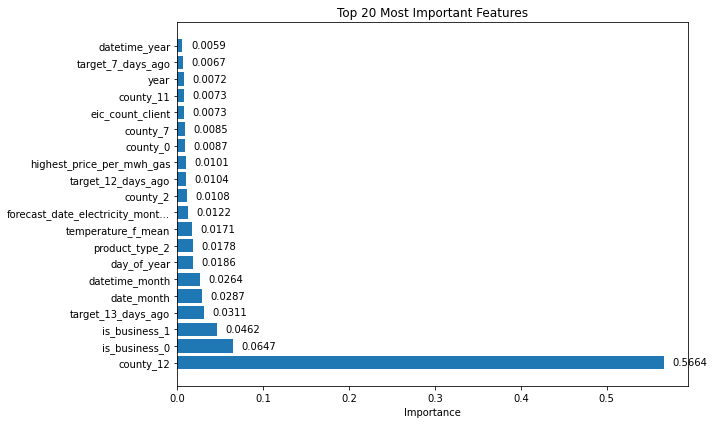

Top 20 Feature Importance:
1. county_12: 0.5664
2. is_business_0: 0.0647
3. is_business_1: 0.0462
4. target_13_days_ago: 0.0311
5. date_month: 0.0287
6. datetime_month: 0.0264
7. day_of_year: 0.0186
8. product_type_2: 0.0178
9. temperature_f_mean: 0.0171
10. forecast_date_electricity_month: 0.0122
11. county_2: 0.0108
12. target_12_days_ago: 0.0104
13. highest_price_per_mwh_gas: 0.0101
14. county_0: 0.0087
15. county_7: 0.0085
16. eic_count_client: 0.0073
17. county_11: 0.0073
18. year: 0.0072
19. target_7_days_ago: 0.0067
20. datetime_year: 0.0059


In [57]:
# Get feature importance from the model
importance = model.feature_importances_

# Create dictionary of feature names and their importance
feature_importance = dict(zip(x_train.columns, importance))

# Sort features by importance (descending)
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Select top 20 features
top_20_features = sorted_importance[:20]
top_features = [x[0] for x in top_20_features]
top_importance = [x[1] for x in top_20_features]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(top_features))
plt.barh(y_pos, top_importance, align='center')
plt.yticks(y_pos, [feature[:30] + '...' if len(feature) > 30 else feature for feature in top_features])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features')

# Add values to the bars
for i, v in enumerate(top_importance):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

# Print the top features and their importance scores in a table
print("Top 20 Feature Importance:")
for i, (feature, importance) in enumerate(top_20_features, 1):
    print(f"{i}. {feature}: {importance:.4f}")

Test MAE = 0.0324
Test RMSE = 0.0777
Test R² score = 0.9757
MAE as % of mean target value = 10.79%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikit_learn-1.5.1-py3.10-macosx-10.9-universal2.egg/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


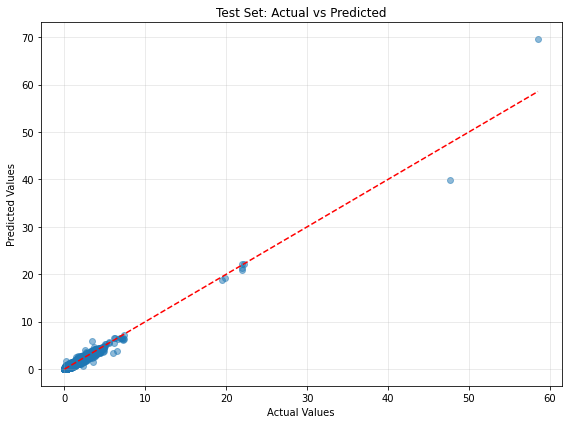

In [58]:
########################################
# STEP 6: Evaluate on test set (Won't be run on test)
########################################

if True:
    model.fit(x_train0, y_train0)
    # Generate predictions on the test set
    y_test_pred = model.predict(x_test)
    
    # Calculate multiple metrics for comprehensive evaluation
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Calculate mean of target for context
    y_test_mean = y_test.mean()
    
    # Print results
    print(f"Test MAE = {test_mae:.4f}")
    print(f"Test RMSE = {test_rmse:.4f}")
    print(f"Test R² score = {test_r2:.4f}")
    print(f"MAE as % of mean target value = {(test_mae/abs(y_test_mean))*100:.2f}%")
    
    # Optional: Create a scatter plot of actual vs. predicted values
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Test Set: Actual vs Predicted')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Predicting Energy Produced

In [59]:
for col in prod.select_dtypes(include=['object', 'category']).columns:
    print(f"{col}: {prod[col].nunique()} unique values")

county: 16 unique values
is_business: 2 unique values
product_type: 4 unique values
is_consumption: 1 unique values


In [60]:

########################################
# STEP 2: Apply "non-learned" data transformations
########################################

# Limited to these 4 feature transformations

# one hot encode categorical columns (increases vc dim)
prod = pd.get_dummies(prod)
print(f"cons.shape={prod.shape}")

# convert non-numeric columns to numeric (no effect on vd dim)
# le = sklearn.preprocessing.LabelEncoder()
# df = df[df.columns[:]].apply(le.fit_transform)
# print(f"df.shape={df.shape}")

# apply the polynomial feature map (increases vc dim)
# poly = sklearn.preprocessing.PolynomialFeatures(3)
# df = poly.fit_transform(df)
# print(f"df.shape={df.shape}")

# apply a random projection (decreases vc dim)
# proj = sklearn.random_projection.GaussianRandomProjection(
#     n_components=120, # output dimension
#     random_state=42,
#     )
# df = proj.fit_transform(df)
# print(f"df.shape={df.shape}")

cons.shape=(1009176, 83)


In [61]:
########################################
# STEP 3: Create train/test sets
########################################

target = prod['target']/prod['installed_capacity_client']
prod = prod.drop(columns=['target', 'installed_capacity_client'])

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# ensure that the ratios sum to 1.0
epsilon = 1e-10
assert(1 - epsilon <= train_ratio + validation_ratio + test_ratio <= 1 + epsilon)

# create train0/test set
x_train0, x_test, y_train0, y_test = sklearn.model_selection.train_test_split(
    prod,
    target,
    test_size=test_ratio,
    random_state=0,
    )
print(f"len(x_train0)={len(x_train0)}")
print(f"len(x_test)={len(x_test)}")

# create train/validation set
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(
    x_train0,
    y_train0,
    test_size=validation_ratio/(train_ratio + validation_ratio),
    random_state=0,
    )
print(f"len(x_train)={len(x_train)}")
print(f"len(x_val)={len(x_val)}")

len(x_train0)=908258
len(x_test)=100918
len(x_train)=756881
len(x_val)=151377


In [62]:
# Preprocess datetime columns
datetime_columns = ['datetime', 'date', 'forecast_date_electricity']  # Replace with actual datetime column names

# Convert datetime columns to numeric features (e.g., year, month, day)
for col in datetime_columns:
    if col in x_train0.columns:
        x_train[col + '_year'] = x_train[col].dt.year
        x_train[col + '_month'] = x_train[col].dt.month
        x_train[col + '_day'] = x_train[col].dt.day
        x_train = x_train.drop(columns=[col])  # Drop the original datetime column

        x_train0[col + '_year'] = x_train0[col].dt.year
        x_train0[col + '_month'] = x_train0[col].dt.month
        x_train0[col + '_day'] = x_train0[col].dt.day
        x_train0 = x_train0.drop(columns=[col])  # Drop the original datetime column

        x_val[col + '_year'] = x_val[col].dt.year
        x_val[col + '_month'] = x_val[col].dt.month
        x_val[col + '_day'] = x_val[col].dt.day
        x_val = x_val.drop(columns=[col])

        x_test[col + '_year'] = x_test[col].dt.year
        x_test[col + '_month'] = x_test[col].dt.month
        x_test[col + '_day'] = x_test[col].dt.day
        x_test = x_test.drop(columns=[col])

# Ensure all columns are numeric
x_train0 = x_train0.apply(pd.to_numeric, errors='coerce')
x_train = x_train.apply(pd.to_numeric, errors='coerce')
x_val = x_val.apply(pd.to_numeric, errors='coerce')
x_test = x_test.apply(pd.to_numeric, errors='coerce')



In [63]:
# Find indices with NaN in y_train, y_train0 y_val, y_test
nan_indices_train = y_train[y_train.isna()].index
nan_indices_train0 = y_train0[y_train0.isna()].index
nan_indices_val = y_val[y_val.isna()].index
nan_indices_test = y_test[y_test.isna()].index

# Drop the corresponding rows from features and target
x_train0 = x_train0.drop(index=nan_indices_train0)
y_train0 = y_train0.drop(index=nan_indices_train0)

x_train = x_train.drop(index=nan_indices_train)
y_train = y_train.drop(index=nan_indices_train)

x_val = x_val.drop(index=nan_indices_val)
y_val = y_val.drop(index=nan_indices_val)

x_test = x_test.drop(index=nan_indices_test)
y_test = y_test.drop(index=nan_indices_test)

In [64]:
# Fill NaN with mean/median/mode for each column
for col in x_train0.columns:
    # For numerical columns, use mean or median
    if x_train0[col].dtype in ['int64', 'float64']:
        # Use median for robustness against outliers
        median_value = x_train0[col].median()
        x_train0[col] = x_train0[col].fillna(median_value)
        x_train[col] = x_train[col].fillna(median_value)
        x_val[col] = x_val[col].fillna(median_value)
        x_test[col] = x_test[col].fillna(median_value)
    else:
        # For categorical columns, use mode (most frequent value)
        mode_value = x_train0[col].mode()[0]
        x_train0[col] = x_train0[col].fillna(mode_value)
        x_train[col] = x_train[col].fillna(mode_value)
        x_val[col] = x_val[col].fillna(mode_value)
        x_test[col] = x_test[col].fillna(mode_value)

In [65]:
########################################
# STEP 5: Train a model
########################################

# NOTE:
# the models below are listed in the order we covered them in class;
# the parameters are listed in the order of the documentation;
# you are responsible for understanding how all specified parameters impact the runtime and/or statistical errors

# Most of our discussions in class is about "error"
# accuracy = 1 - error

model = xgb.XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',  # Objective for regression
    max_depth=10,
    min_child_weight=1,
    colsample_bytree=0.8,
    subsample=0.8,
    n_estimators=2000,
    learning_rate=0.01,
    reg_lambda=1,
    reg_alpha=0,
    random_state=42
)


model.fit(x_train, y_train)

# Make predictions
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

# Calculate R² scores
validation_r2 = model.score(x_val, y_val)
train_r2 = model.score(x_train, y_train)

# Calculate Mean Absolute Error
train_mae = mean_absolute_error(y_train, y_train_pred)
validation_mae = mean_absolute_error(y_val, y_val_pred)

# Calculate Root Mean Squared Error
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
validation_rmse = mean_squared_error(y_val, y_val_pred, squared=False)

# Print all metrics
print(f"Training metrics:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print("\nValidation metrics:")
print(f"  R² Score: {validation_r2:.4f}")
print(f"  MAE: {validation_mae:.4f}")
print(f"  RMSE: {validation_rmse:.4f}")

Training metrics:
  R² Score: 0.9836
  MAE: 0.0076
  RMSE: 0.0176

Validation metrics:
  R² Score: 0.9601
  MAE: 0.0104
  RMSE: 0.0275


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikit_learn-1.5.1-py3.10-macosx-10.9-universal2.egg/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikit_learn-1.5.1-py3.10-macosx-10.9-universal2.egg/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [66]:
target_mean = y_train.mean()
target_std = y_train.std()
print(f"Target mean: {target_mean:.4f}, std: {target_std:.4f}")
print(f"MAE: {validation_mae:.4f}")
print(f"MAE as % of mean: {(validation_mae/abs(target_mean))*100:.2f}%")

Target mean: 0.0625, std: 0.1372
MAE: 0.0104
MAE as % of mean: 16.63%


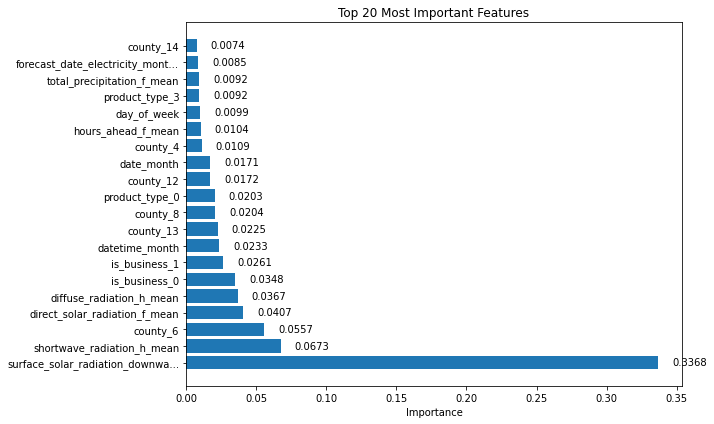

Top 20 Feature Importance:
1. surface_solar_radiation_downwards_f_mean: 0.3368
2. shortwave_radiation_h_mean: 0.0673
3. county_6: 0.0557
4. direct_solar_radiation_f_mean: 0.0407
5. diffuse_radiation_h_mean: 0.0367
6. is_business_0: 0.0348
7. is_business_1: 0.0261
8. datetime_month: 0.0233
9. county_13: 0.0225
10. county_8: 0.0204
11. product_type_0: 0.0203
12. county_12: 0.0172
13. date_month: 0.0171
14. county_4: 0.0109
15. hours_ahead_f_mean: 0.0104
16. day_of_week: 0.0099
17. product_type_3: 0.0092
18. total_precipitation_f_mean: 0.0092
19. forecast_date_electricity_month: 0.0085
20. county_14: 0.0074


In [67]:
# Get feature importance from the model
importance = model.feature_importances_

# Create dictionary of feature names and their importance
feature_importance = dict(zip(x_train.columns, importance))

# Sort features by importance (descending)
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Select top 20 features
top_20_features = sorted_importance[:20]
top_features = [x[0] for x in top_20_features]
top_importance = [x[1] for x in top_20_features]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(top_features))
plt.barh(y_pos, top_importance, align='center')
plt.yticks(y_pos, [feature[:30] + '...' if len(feature) > 30 else feature for feature in top_features])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features')

# Add values to the bars
for i, v in enumerate(top_importance):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

# Print the top features and their importance scores in a table
print("Top 20 Feature Importance:")
for i, (feature, importance) in enumerate(top_20_features, 1):
    print(f"{i}. {feature}: {importance:.4f}")

Test MAE = 0.0102
Test RMSE = 0.0252
Test R² score = 0.9663
MAE as % of mean target value = 16.14%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikit_learn-1.5.1-py3.10-macosx-10.9-universal2.egg/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


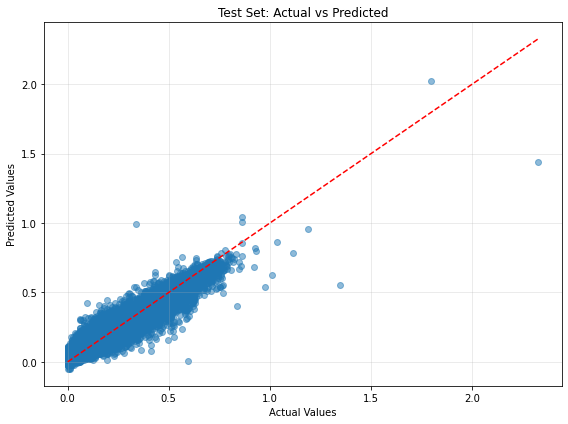

In [68]:
########################################
# STEP 6: Evaluate on test set (Won't be run on test)
########################################

if True:
    model.fit(x_train0, y_train0)
    # Generate predictions on the test set
    y_test_pred = model.predict(x_test)
    
    # Calculate multiple metrics for comprehensive evaluation
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Calculate mean of target for context
    y_test_mean = y_test.mean()
    
    # Print results
    print(f"Test MAE = {test_mae:.4f}")
    print(f"Test RMSE = {test_rmse:.4f}")
    print(f"Test R² score = {test_r2:.4f}")
    print(f"MAE as % of mean target value = {(test_mae/abs(y_test_mean))*100:.2f}%")
    
    # Optional: Create a scatter plot of actual vs. predicted values
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Test Set: Actual vs Predicted')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()